# INFO 212: Data Science Programming 1
___

### Week 8: Data Wrangling, Aggregation and Group Operations
___

### Mon., 21, 2018, and Wed., May 23, 2018
---

**Question:**
- What capabilities does Python provide for complex group operations? 

**Objectives:**
- Split a pandas object into pieces using one or more keys (in the form of functions, arrays, or DataFrame column names)
- Calculate group summary statistics, like count, mean, or standard deviation, or a user-defined function
- Apply within-group transformations or other manipulations, like normalization, linear regression, rank, or subset selection
- Compute pivot tables and cross-tabulations
- Perform quantile analysis and other statistical group analyses

In [2]:
import numpy as np
import pandas as pd
PREVIOUS_MAX_ROWS = pd.options.display.max_rows
pd.options.display.max_rows = 20
np.random.seed(12345)
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))
np.set_printoptions(precision=4, suppress=True)

## Working with Strings
### Regular Expressions
Regular expressions provide a flexible way to search or match (often more complex)
string patterns in text. A single expression, commonly called a regex, is a string
formed according to the regular expression language. Python’s built-in re module is
responsible for applying regular expressions to strings.

The re module functions fall into three categories: pattern matching, substitution,
and splitting. Naturally these are all related; a regex describes a pattern to locate in the
text, which can then be used for many purposes. 

Suppose we wanted to split a string with a variable number of whitespace characters
(tabs, spaces, and newlines). The regex describing one or more whitespace characters
is \s+:

```
import re
text = "foo    bar\t baz  \tqux"
re.split('\s+', text)```

When you call re.split('\s+', text), the regular expression is first compiled, and
then its split method is called on the passed text. You can compile the regex yourself
with re.compile, forming a reusable regex object:

```
regex = re.compile('\s+')
regex.split(text)```

If, instead, you wanted to get a list of all patterns matching the regex, you can use the
findall method:

```
regex.findall(text)```

match and search are closely related to findall. While findall returns all matches
in a string, search returns only the first match. More rigidly, match only matches at
the beginning of the string. As a less trivial example, let’s consider a block of text and
a regular expression capable of identifying most email addresses:

```
text = """Dave dave@google.com
Steve steve@gmail.com
Rob rob@gmail.com
Ryan ryan@yahoo.com
"""
pattern = r'[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,4}'

# re.IGNORECASE makes the regex case-insensitive
regex = re.compile(pattern, flags=re.IGNORECASE)```

Using findall on the text produces a list of the email addresses:

```
regex.findall(text)```

search returns a special match object for the first email address in the text. For the
preceding regex, the match object can only tell us the start and end position of the
pattern in the string:

```
m = regex.search(text)
m
text[m.start():m.end()]```

regex.match returns None, as it only will match if the pattern occurs at the start of the
string:

```
print(regex.match(text))```

Relatedly, sub will return a new string with occurrences of the pattern replaced by the
a new string:

```
print(regex.sub('REDACTED', text))```

Suppose you wanted to find email addresses and simultaneously segment each
address into its three components: username, domain name, and domain suffix. To
do this, put parentheses around the parts of the pattern to segment:

```
pattern = r'([A-Z0-9._%+-]+)@([A-Z0-9.-]+)\.([A-Z]{2,4})'
regex = re.compile(pattern, flags=re.IGNORECASE)```

A match object produced by this modified regex returns a tuple of the pattern components
with its groups method:

```
m = regex.match('wesm@bright.net')
m.groups()```

findall returns a list of tuples when the pattern has groups:

```
regex.findall(text)```

sub also has access to groups in each match using special symbols like \1 and \2. The
symbol \1 corresponds to the first matched group, \2 corresponds to the second, and
so forth:

```
print(regex.sub(r'Username: \1, Domain: \2, Suffix: \3', text))```

### Basic Patterns
The power of regular expressions is that they can specify patterns, not just fixed characters. Here are the most basic patterns which match single chars:

* a, X, 9, < -- ordinary characters just match themselves exactly. The meta-characters which do not match themselves because they have special meanings are: `. ^ $ * + ? { [ ] \ | ( )`
* . (a period) -- matches any single character except newline '\n'
* \w -- (lowercase w) matches a "word" character: a letter or digit or underbar [a-zA-Z0-9_]. Note that although "word" is the mnemonic for this, it only matches a single word char, not a whole word. \W (upper case W) matches any non-word character.
* \b -- boundary between word and non-word
* \s -- (lowercase s) matches a single whitespace character -- space, newline, return, tab, form `[ \n\r\t\f]`. 
* \S (upper case S) matches any non-whitespace character.
* \t, \n, \r -- tab, newline, return
* \d -- decimal digit [0-9] (some older regex utilities do not support but \d, but they all support \w and \s)
* ^ = start, $ = end -- match the start or end of the string
* \ -- inhibit the "specialness" of a character. So, for example, use \. to match a period or \\ to match a slash. If you are unsure if a character has special meaning, such as '@', you can put a slash in front of it, \@, to make sure it is treated just as a character.

### Excercise 
If a row in a DataFrame belongs to multiple categories, things are a bit more complicated.
Let’s look at the MovieLens 1M dataset.

```
mnames = ['movie_id', 'title', 'genres']
movies = pd.read_table('datasets/movielens/movies.dat', sep='::',
.....: header=None, names=mnames)
movies[:10]
```

Adding indicator variables for each genre requires a little bit of wrangling. First, we
extract the list of unique genres in the dataset:
```
all_genres = []
for x in movies.genres:
.....: all_genres.extend(x.split('|'))
genres = pd.unique(all_genres)

genres
```

One way to construct the indicator DataFrame is to start with a DataFrame of all
zeros:
```
zero_matrix = np.zeros((len(movies), len(genres)))
dummies = pd.DataFrame(zero_matrix, columns=genres)
```
Now, iterate through each movie and set entries in each row of dummies to 1. To do
this, we use the dummies.columns to compute the column indices for each genre:
```
gen = movies.genres[0]
gen.split('|')

dummies.columns.get_indexer(gen.split('|'))
```
Then, we can use .iloc to set values based on these indices:
```
for i, gen in enumerate(movies.genres):
.....: indices = dummies.columns.get_indexer(gen.split('|'))
.....: dummies.iloc[i, indices] = 1
.....:
```
Then, as before, you can combine this with movies:
```
movies_windic = movies.join(dummies.add_prefix('Genre_'))
movies_windic.iloc[0]
```


## GroupBy Mechanics

Categorizing a dataset and applying a function to each group, whether an aggregation
or transformation, is often a critical component of a data analysis workflow. After
loading, merging, and preparing a dataset, you may need to compute group statistics
or possibly pivot tables for reporting or visualization purposes. pandas provides a
flexible groupby interface, enabling you to slice, dice, and summarize datasets in a
natural way.

Hadley Wickham, an author of many popular packages for the R programming language,
coined the term split-apply-combine for describing group operations. In the
first stage of the process, data contained in a pandas object, whether a Series, Data‐
Frame, or otherwise, is split into groups based on one or more keys that you provide.
The splitting is performed on a particular axis of an object. For example, a DataFrame
can be grouped on its rows (axis=0) or its columns (axis=1). Once this is done, a
function is applied to each group, producing a new value. Finally, the results of all
those function applications are combined into a result object. The form of the resulting
object will usually depend on what’s being done to the data.

![](split-apply-combine.PNG)

To get started, here is a small tabular dataset as a DataFrame:

```
df = pd.DataFrame({'key1' : ['a', 'a', 'b', 'b', 'a'],
                   'key2' : ['one', 'two', 'one', 'two', 'one'],
                   'data1' : np.random.randn(5),
                   'data2' : np.random.randn(5)})
df```

In [3]:
df = pd.DataFrame({'key1' : ['a', 'a', 'b', 'b', 'a'],
                   'key2' : ['one', 'two', 'one', 'two', 'one'],
                   'data1' : np.random.randn(5),
                   'data2' : np.random.randn(5)})
df

,data1,data2,key1,key2
0,-0.204708,1.393406,a,one
1,0.478943,0.092908,a,two
2,-0.519439,0.281746,b,one
3,-0.555730,0.769023,b,two
4,1.965781,1.246435,a,one


Suppose you wanted to compute the mean of the data1 column using the labels from
key1. There are a number of ways to do this. One is to access data1 and call groupby
with the column (a Series) at key1:

```
grouped = df['data1'].groupby(df['key1'])
grouped```

In [6]:
grouped = df['data1'].groupby(df['key1'])
grouped

This grouped variable is now a GroupBy object. It has not actually computed anything
yet except for some intermediate data about the group key df['key1']. The idea is
that this object has all of the information needed to then apply some operation to
each of the groups. For example, to compute group means we can call the GroupBy’s
mean method:

```
grouped.mean()```

In [7]:
grouped.mean()

key1
a    0.746672
b   -0.537585
Name: data1, dtype: float64

In [8]:
grouped.max()

key1
a    1.965781
b   -0.519439
Name: data1, dtype: float64

The result index has the name 'key1' because the DataFrame column ```df['key1']``` did.

If instead we had passed multiple arrays as a list, we’d get something different:

```
means = df['data1'].groupby([df['key1'], df['key2']]).mean()
means```

In [9]:
means = df['data1'].groupby([df['key1'], df['key2']]).mean()
means

key1  key2
a     one     0.880536
      two     0.478943
b     one    -0.519439
      two    -0.555730
Name: data1, dtype: float64

Here we grouped the data using two keys, and the resulting Series now has a **hierarchical
index** consisting of the unique pairs of keys observed. We can unstack the hierarchical index as:

```
means.unstack()```

In [10]:
means.unstack()

key2,one,two
key1,,
a,0.880536,0.478943
b,-0.519439,-0.555730


In this example, the group keys are all Series, though they could be any arrays of the
right length:

```
states = np.array(['Ohio', 'California', 'California', 'Ohio', 'Ohio'])
years = np.array([2005, 2005, 2006, 2005, 2006])
df['data1'].groupby([states, years]).mean()```

In [12]:
states = np.array(['Ohio', 'California', 'California', 'Ohio', 'Ohio'])
years = np.array([2005, 2005, 2006, 2005, 2006])
df['data1'].groupby([states, years]).mean().unstack()

,2005,2006
California,0.478943,-0.519439
Ohio,-0.380219,1.965781


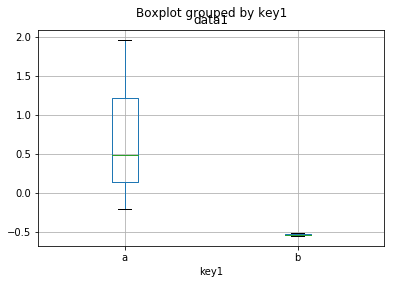

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
df.boxplot(column = 'data1', by ='key1')

Frequently the grouping information is found in the same DataFrame as the data you
want to work on. In that case, you can pass column names (whether those are strings,
numbers, or other Python objects) as the group keys:

```
df.groupby('key1').mean()
df.groupby(['key1', 'key2']).mean()```

You may have noticed in the first case `df.groupby('key1').mean()` that there is no
key2 column in the result. Because `df['key2']` is not numeric data, it is said to be a
nuisance column, which is therefore excluded from the result. By default, all of the
numeric columns are aggregated, though it is possible to filter down to a subset, as
you’ll see soon.

Regardless of the objective in using groupby, a generally useful GroupBy method is
size, which returns a Series containing group sizes:

```
df.groupby(['key1', 'key2']).size()```

In [16]:
df.groupby(['key1', 'key2']).size()

key1  key2
a     one     2
      two     1
b     one     1
      two     1
dtype: int64

### Iterating Over Groups
The GroupBy object supports iteration, generating a sequence of 2-tuples containing
the group name along with the chunk of data. Consider the following:

```
for name, group in df.groupby('key1'):
    print(name)
    print(group)```

In [17]:
for name, group in df.groupby('key1'):
    print(name)
    print(group)

a
      data1     data2 key1 key2
0 -0.204708  1.393406    a  one
1  0.478943  0.092908    a  two
4  1.965781  1.246435    a  one
b
      data1     data2 key1 key2
2 -0.519439  0.281746    b  one
3 -0.555730  0.769023    b  two


In [20]:
df.groupby('key1').

AttributeError: Cannot access callable attribute 'iloc' of 'DataFrameGroupBy' objects, try using the 'apply' method

In the case of multiple keys, the first element in the tuple will be a tuple of key values:

```
for (k1, k2), group in df.groupby(['key1', 'key2']):
    print((k1, k2))
    print(group)```

In [21]:
for (k1, k2), group in df.groupby(['key1', 'key2']):
    print((k1, k2))
    print(group)

('a', 'one')
      data1     data2 key1 key2
0 -0.204708  1.393406    a  one
4  1.965781  1.246435    a  one
('a', 'two')
      data1     data2 key1 key2
1  0.478943  0.092908    a  two
('b', 'one')
      data1     data2 key1 key2
2 -0.519439  0.281746    b  one
('b', 'two')
     data1     data2 key1 key2
3 -0.55573  0.769023    b  two


By default groupby groups on axis=0, but you can group on any of the other axes.
For example, we could group the columns of our example df here by dtype like so:

```
df.dtypes```

In [22]:
df.dtypes

data1    float64
data2    float64
key1      object
key2      object
dtype: object

```
grouped = df.groupby(df.dtypes, axis=1)```

In [24]:
grouped = df.groupby(df.dtypes, axis=1)
grouped

We can print out the groups like so:

```
for dtype, group in grouped:
    print(dtype)
    print(group)```

In [25]:
for dtype, group in grouped:
    print(dtype)
    print(group)

float64
      data1     data2
0 -0.204708  1.393406
1  0.478943  0.092908
2 -0.519439  0.281746
3 -0.555730  0.769023
4  1.965781  1.246435
object
  key1 key2
0    a  one
1    a  two
2    b  one
3    b  two
4    a  one


### Selecting a Column or Subset of Columns

```
df.groupby('key1')['data1']
df.groupby('key1')[['data2']]```

is equivalent to

```
df['data1'].groupby(df['key1'])
df[['data2']].groupby(df['key1'])```

Especially for large datasets, it may be desirable to aggregate only a few columns. For
example, in the preceding dataset, to compute means for just the data2 column and
get the result as a DataFrame, we could write:

```
df.groupby(['key1', 'key2'])[['data2']].mean()```

In [26]:
df.groupby(['key1', 'key2'])[['data2']].mean()

data2
key1 key2          
a    one   1.319920
     two   0.092908
b    one   0.281746
     two   0.769023

The object returned by this indexing operation is a grouped DataFrame if a list or
array is passed or a grouped Series if only a single column name is passed as a scalar:

```
s_grouped = df.groupby(['key1', 'key2'])['data2']
s_grouped```

In [28]:
s_grouped = df.groupby(['key1', 'key2'])['data2']
type(s_grouped)

pandas.core.groupby.SeriesGroupBy

```
s_grouped.mean()```

In [29]:
s_grouped.mean()

key1  key2
a     one     1.319920
      two     0.092908
b     one     0.281746
      two     0.769023
Name: data2, dtype: float64

### Grouping with Dicts and Series
Grouping information may exist in a form other than an array. Let’s consider another
example DataFrame:

```
people = pd.DataFrame(np.random.randn(5, 5),
                      columns=['a', 'b', 'c', 'd', 'e'],
                      index=['Joe', 'Steve', 'Wes', 'Jim', 'Travis'])
people.iloc[2:3, [1, 2]] = np.nan # Add a few NA values
people```

In [30]:
people = pd.DataFrame(np.random.randn(5, 5),
                      columns=['a', 'b', 'c', 'd', 'e'],
                      index=['Joe', 'Steve', 'Wes', 'Jim', 'Travis'])
people.iloc[2:3, [1, 2]] = np.nan # Add a few NA values
people

,a,b,c,d,e
Joe,1.007189,-1.296221,0.274992,0.228913,1.352917
Steve,0.886429,-2.001637,-0.371843,1.669025,-0.438570
Wes,-0.539741,NaN,NaN,-1.021228,-0.577087
Jim,0.124121,0.302614,0.523772,0.000940,1.343810
Travis,-0.713544,-0.831154,-2.370232,-1.860761,-0.860757


Now, suppose I have a group correspondence for the columns and want to sum
together the columns by group:

```
mapping = {'a': 'red', 'b': 'red', 'c': 'blue',
           'd': 'blue', 'e': 'red', 'f' : 'orange'}```

In [31]:
mapping = {'a': 'red', 'b': 'red', 'c': 'blue',
           'd': 'blue', 'e': 'red', 'f' : 'orange'}

Now, you could construct an array from this dict to pass to groupby, but instead we
can just pass the dict (I included the key 'f' to highlight that unused grouping keys
are OK):

```
by_column = people.groupby(mapping, axis=1)
by_column.sum()```

In [32]:
by_column = people.groupby(mapping, axis=1)
by_column.sum()

,blue,red
Joe,0.503905,1.063885
Steve,1.297183,-1.553778
Wes,-1.021228,-1.116829
Jim,0.524712,1.770545
Travis,-4.230992,-2.405455


The same functionality holds for Series, which can be viewed as a fixed-size mapping:

```
map_series = pd.Series(mapping)
map_series
people.groupby(map_series, axis=1).count()```

## Data Aggregation
Aggregations refer to any data transformation that produces scalar values from
arrays. The preceding examples have used several of them, including mean, count,
min, and sum. Many common aggregations
have optimized implementations. However, you are not limited to only this set of
methods.

```
df```

In [33]:
df

,data1,data2,key1,key2
0,-0.204708,1.393406,a,one
1,0.478943,0.092908,a,two
2,-0.519439,0.281746,b,one
3,-0.555730,0.769023,b,two
4,1.965781,1.246435,a,one


You can use aggregations of your own devising and additionally call any method that
is also defined on the grouped object. For example, you might recall that quantile
computes sample quantiles of a Series or a DataFrame’s columns.

```
grouped = df.groupby('key1')
grouped['data1'].quantile(0.9)```

In [35]:
grouped = df.groupby('key1')
grouped['data1'].quantile(0.9)

key1
a    1.668413
b   -0.523068
Name: data1, dtype: float64

To use your own aggregation functions, pass any function that aggregates an array to
the aggregate or agg method:

```
def peak_to_peak(arr):
    return arr.max() - arr.min()
grouped.agg(peak_to_peak)```

In [36]:
def peak_to_peak(arr):
    return arr.max() - arr.min()
grouped.agg(peak_to_peak)

,data1,data2
key1,,
a,2.170488,1.300498
b,0.036292,0.487276


You may notice that some methods like describe also work, even though they are not
aggregations, strictly speaking:

```
grouped.describe()```

In [37]:
grouped.describe()

data1                                                              \
     count      mean       std       min       25%       50%       75%   
key1                                                                     
a      3.0  0.746672  1.109736 -0.204708  0.137118  0.478943  1.222362   
b      2.0 -0.537585  0.025662 -0.555730 -0.546657 -0.537585 -0.528512   

               data2                                                    \
           max count      mean       std       min       25%       50%   
key1                                                                     
a     1.965781   3.0  0.910916  0.712217  0.092908  0.669671  1.246435   
b    -0.519439   2.0  0.525384  0.344556  0.281746  0.403565  0.525384   

                          
           75%       max  
key1                      
a     1.319920  1.393406  
b     0.647203  0.769023

### Column-Wise and Multiple Function Application
Let’s return to the tipping dataset from earlier examples. After loading it with
read_csv, we add a tipping percentage column tip_pct:

```
tips = pd.read_csv('examples/tips.csv')
# Add tip percentage of total bill
tips['tip_pct'] = tips['tip'] / tips['total_bill']
tips[:6]```

As you’ve already seen, aggregating a Series or all of the columns of a DataFrame is a
matter of using aggregate with the desired function or calling a method like mean or
std. However, you may want to aggregate using a different function depending on the
column, or multiple functions at once. Fortunately, this is possible to do, which I’ll
illustrate through a number of examples. First, I’ll group the tips by day and smoker:

```
grouped = tips.groupby(['day', 'smoker'])```

Note that for descriptive statistics, you can pass the name of
the function as a string:

```
grouped_pct = grouped['tip_pct']
grouped_pct.agg('mean')```

If you pass a list of functions or function names instead, you get back a DataFrame
with column names taken from the functions:

```
grouped_pct.agg(['mean', 'std', peak_to_peak])```

Here we passed a list of aggregation functions to agg to evaluate indepedently on the
data groups.

You don’t need to accept the names that GroupBy gives to the columns; notably,
lambda functions have the name '<lambda>', which makes them hard to identify
(you can see for yourself by looking at a function’s __name__ attribute). Thus, if you
pass a list of (name, function) tuples, the first element of each tuple will be used as
the DataFrame column names (you can think of a list of 2-tuples as an ordered
mapping):

```
grouped_pct.agg([('foo', 'mean'), ('bar', np.std)])```

With a DataFrame you have more options, as you can specify a list of functions to
apply to all of the columns or different functions per column. To start, suppose we
wanted to compute the same three statistics for the tip_pct and total_bill
columns:

```
functions = ['count', 'mean', 'max']
result = grouped['tip_pct', 'total_bill'].agg(functions)
result```

As you can see, the resulting DataFrame has hierarchical columns, the same as you
would get aggregating each column separately and using concat to glue the results
together using the column names as the keys argument:

```
result['tip_pct']```

As before, a list of tuples with custom names can be passed:

```
ftuples = [('Durchschnitt', 'mean'), ('Abweichung', np.var)]
grouped['tip_pct', 'total_bill'].agg(ftuples)```

Now, suppose you wanted to apply potentially different functions to one or more of
the columns. To do this, pass a dict to agg that contains a mapping of column names
to any of the function specifications listed so far:

```
grouped.agg({'tip' : np.max, 'size' : 'sum'})
grouped.agg({'tip_pct' : ['min', 'max', 'mean', 'std'],
             'size' : 'sum'})```